# Notebook 4: STR Specialization and Phase-Preserving Alignment

This notebook extends the NW-flex framework to handle **short tandem repeats**
(STRs), where the flexible block $Z$ consists of repeated copies of a short
motif $R$. We develop a phase-preserving EP pattern that correctly aligns
reads whose repeat content may start or end mid-motif.

## Overview

In this notebook we:

1. **Define phased repeats** $Z^* = \mathrm{suf}(R,a) \cdot R^M \cdot \mathrm{pre}(R,b)$,
   representing repeat regions that may enter or exit the motif at arbitrary phases.

2. **Enumerate valid phase combinations** $(a, b, M)$ under the constraint
   $M + \mathbf{1}_{\{a>0\}} + \mathbf{1}_{\{b>0\}} \le N$.

3. **Build the STR-specific EP pattern** using `build_EP_STR_phase`, which
   allows entry from the leader row and exit only through phase-compatible rows.

4. **Validate correctness** by verifying that NW-flex produces the expected
   perfect-match score for all valid phase combinations.

5. **Demonstrate phase-wise monotonicity** in the DP grid: for fixed column $j$
   and motif phase $r$, scores along rows $i = s+1+r+nk$ are non-decreasing.

6. **Extend to multi-block STRs** (compound repeats) using `build_EP_multi_STR_phase`.

This notebook builds on:

- **Notebook 1**: Needleman–Wunsch basics and the Gotoh three-state DP.
- **Notebook 2**: NW-flex core with extra-predecessor (EP) patterns.
- **Notebook 3**: Validation of NW-flex optimality for single-block $A \cdot Z \cdot B$.

## Setup and imports

In [ ]:
# 🧙 Notebook magic: autoreload modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display

# STR repeat utilities
from nwflex.repeats import (
    STRLocus,
    CompoundSTRLocus,
    phase_repeat,
    infer_abM_from_jumps,
)

# EP pattern builders
from nwflex.ep_patterns import (
    build_EP_standard,
    build_EP_single_block,
    build_EP_STR_phase,
    build_EP_multi_STR_phase,
)

# Alignment functions
from nwflex.aligners import align_with_EP

# Default scoring
from nwflex.default import get_default_scoring

# Plotting
from nwflex.plot import (
    plot_flex_matrices_publication,
    plot_ep_comparison,
    REGION_FILL_COLORS,
    REGION_LABEL_COLORS,
)

from nwflex.plot.colors import HEATMAP_COLORMAPS
grid_color_map = HEATMAP_COLORMAPS['diverging']

# Set pandas display options
pd.set_option('display.max_colwidth', 30)

### Scoring scheme

We use the same default scoring as in the other notebooks:
match = +5, mismatch = -5, gap-open = -20, gap-extend = -1.

In [2]:
# Load default scoring scheme
score_matrix, gap_open, gap_extend, alphabet_to_index = get_default_scoring()

# Extract match score for later validation
match_score = score_matrix[alphabet_to_index['A'], alphabet_to_index['A']]

print(f"Scoring: match = {match_score}, mismatch = {score_matrix[0,1]}, "
      f"gap_open = {gap_open}, gap_extend = {gap_extend}")

Scoring: match = 5.0, mismatch = -5.0, gap_open = -20.0, gap_extend = -1.0


## Defining an STR locus

We consider an STR locus of the form
$$
X = A \cdot R^{N} \cdot B,
$$
where:

- $A$ is the left flank sequence,
- $R$ is the repeat motif of length $k = |R|$,
- $N$ is the number of motif copies in the reference,
- $B$ is the right flank sequence.

In our running example we use:

- $A = \texttt{GAG}$
- $R = \texttt{ACT}$ (motif length $k = 3$)
- $N = 6$
- $B = \texttt{GTCA}$

The `STRLocus` class from `nwflex.repeats` encapsulates this structure and
provides convenient properties for the derived quantities.

In [3]:
# Define the STR locus
locus = STRLocus(A="GAG", R="ACT", N=6, B="GTCA")

print(locus)
print()
print(f"Reference X: {locus.X}")

STRLocus(A='GAG', R='ACT', N=6, B='GTCA')
  X = 'GAGACTACTACTACTACTACTGTCA' (n=25)
  s=3, e=21, k=3

Reference X: GAGACTACTACTACTACTACTGTCA


### Phased repeats inside a read

A read $Y$ from this locus may have a repeat region $Z^*$ that differs from
the reference $Z = R^N$. In particular, $Z^*$ may:

- Start mid-motif (e.g., begin at the second base of $R$),
- End mid-motif (e.g., include only the first base of the final $R$),
- Have a different number of complete motif copies.

To describe such phased repeats, we define:

- $\mathrm{pre}(R, b)$: the length-$b$ **prefix** of $R$,
- $\mathrm{suf}(R, a)$: the length-$a$ **suffix** of $R$.

Given integers $a, b, M \ge 0$, we define a **phased repeat block**:
$$
Z^* = \mathrm{phase}(R, a, b, M)
    = \mathrm{suf}(R, a) \cdot R^{M} \cdot \mathrm{pre}(R, b).
$$

Intuitively:
- $Z^*$ may start in the middle of a motif (suffix of length $a$),
- contain $M$ full copies of $R$,
- and end in the middle of the next motif (prefix of length $b$).

The corresponding read is $Y = A \cdot Z^* \cdot B$.

In [ ]:
# Example: a = 2, b = 1, M = 2
a, b, M = 2, 1, 2

# Build Z* using phase_repeat from the library
Zstar = phase_repeat(locus.R, a, b, M)

# Build the read Y
Y = locus.build_locus_variant(a, b, M)

print(f"Motif R = '{locus.R}' (k = {locus.k})")
print(f"Parameters: a = {a}, b = {b}, M = {M}")
print()
print(f"suf(R, {a}) = '{locus.R[-a:] if a > 0 else ''}'")
print(f"R^{M} = '{locus.R * M}'")
print(f"pre(R, {b}) = '{locus.R[:b] if b > 0 else ''}'")
print()
print(f"Z* = phase(R, {a}, {b}, {M}) = '{Zstar}'")
print(f"Y  = A + Z* + B = '{Y}'")

Motif R = 'ACT' (k = 3)
Parameters: a = 2, b = 1, M = 2

suf(R, 2) = 'CT'
R^2 = 'ACTACT'
pre(R, 1) = 'A'

Z* = phase(R, 2, 1, 2) = 'CTACTACTA'
Y  = A + Z* + B = 'GAGCTACTACTAGTCA'


### The phase constraint

We restrict attention to reads $Y = A \cdot Z^* \cdot B$ whose repeat content
does not exceed that of the reference $X = A \cdot R^N \cdot B$. A convenient
way to express this is:
$$
M + \mathbf{1}_{\{a>0\}} + \mathbf{1}_{\{b>0\}} \;\le\; N,
$$
where $\mathbf{1}_{\{a>0\}}$ is $1$ if $a > 0$ and $0$ otherwise.

In words:
- Each full motif contributes $1$ to $M$,
- A nonempty suffix $\mathrm{suf}(R, a)$ behaves like an additional partial repeat on the left,
- A nonempty prefix $\mathrm{pre}(R, b)$ behaves like an additional partial repeat on the right.

Thus the maximal allowed $Z^*$ (in terms of repeat content) is any phased block
with parameters $(a, b, M)$ satisfying this constraint.

### Enumerating all valid phase combinations

Given the constraint $M + \mathbf{1}_{\{a>0\}} + \mathbf{1}_{\{b>0\}} \le N$,
we can enumerate all valid $(a, b, M)$ triples that produce a phased repeat
$Z^*$ compatible with the reference.

For each combination:
- $a \in \{0, 1, \ldots, k-1\}$ determines the entry phase (suffix length of $R$),
- $b \in \{0, 1, \ldots, k-1\}$ determines the exit phase (prefix length of $R$),
- $M \ge 0$ is the number of complete motif copies.

The `valid_combinations()` function generates all such triples.

In [ ]:
# Generate all valid (a, b, M) combinations for this locus
valid_combos = list(locus.valid_combinations())
n_combos = len(valid_combos)

print(f"Valid (a, b, M) combinations for N={locus.N}, k={locus.k}: {n_combos}")
print()

# Build a table showing all combinations
results = []
for a_i, b_i, M_i in valid_combos:
    Zstar_i = phase_repeat(locus.R, a_i, b_i, M_i)
    Y_i = locus.build_locus_variant(a_i, b_i, M_i)
    overhead = (1 if a_i > 0 else 0) + (1 if b_i > 0 else 0)
    results.append({
        'a': a_i,
        'b': b_i,
        'M': M_i,
        'overhead': overhead,
        'total': M_i + overhead,
        '|Z*|': len(Zstar_i),
        'Z*': Zstar_i,
    })

df_combos = pd.DataFrame(results)
caption = f"All valid (a, b, M) combinations for R = '{locus.R}', N = {locus.N}"
styled = df_combos.style\
    .set_caption(caption)\
    .set_properties(**{'white-space': 'nowrap', 'padding': '2px 6px'})

display(styled)

Valid (a, b, M) combinations for N=6, k=3: 51



,a,b,M,overhead,total,|Z*|,Z*
0,0,0,0,0,0,0,
1,0,0,1,0,1,3,ACT
2,0,0,2,0,2,6,ACTACT
3,0,0,3,0,3,9,ACTACTACT
4,0,0,4,0,4,12,ACTACTACTACT
5,0,0,5,0,5,15,ACTACTACTACTACT
6,0,0,6,0,6,18,ACTACTACTACTACTACT
7,0,1,0,1,1,1,A
8,0,1,1,1,2,4,ACTA
9,0,1,2,1,3,7,ACTACTA


## STR-specific EP pattern

We now build the STR-specific EP pattern that allows the DP to discover the
optimal phase parameters $(a, b, M)$ automatically.

Recall from Notebook 2 that for a single flexible block $X = A \cdot Z \cdot B$,
we define:
- **Leader row** $s = |A|$: the last row of flank $A$,
- **Closer row** $e + 1$: the first row of flank $B$, where $e = |A| + |Z|$.

For the STR case where $Z = R^N$, we modify the exit condition to preserve
motif phase:

**Entry into the block**: For rows $i \in \{s+1, \ldots, e\}$ inside the repeat
block, we set $E(i) = \{s\}$. This allows the alignment to jump from the leader
row $s$ into any position within the block, effectively choosing the entry phase $a$.

**Exit from the block**: At the closer row $e+1$, we set
$$
E(e+1) = \{s,\; e-k+1,\; e-k+2,\; \ldots,\; e-1\}.
$$

The key insight is that only the last $k$ rows of the block (plus the leader $s$)
can exit to row $e+1$. This restriction enforces **phase-compatible exits**: the
departure row $i$ determines the exit phase $b = (i - e) \mod k$.

The leader $s$ appears in $E(e+1)$ to handle the case where the read has no repeat
content at all ($a = b = M = 0$), allowing the alignment to skip the entire block.

In [6]:
# Build the three EP patterns for comparison
n = locus.n
s, e, k = locus.s, locus.e, locus.k

EP_standard = build_EP_standard(n)
EP_block = build_EP_single_block(n, s, e)
EP_str = build_EP_STR_phase(n, s, e, k)

print(f"Reference length n = {n}")
print(f"Leader row s = {s}, Closer row e+1 = {e+1}, Motif length k = {k}")
print()

# Show the EP sets for the closer row
print("Extra predecessors at closer row (e+1):")
print(f"  Single-block: E({e+1}) = {EP_block[e+1]}")
print(f"  STR-phase:    E({e+1}) = {EP_str[e+1]}")

Reference length n = 25
Leader row s = 3, Closer row e+1 = 22, Motif length k = 3

Extra predecessors at closer row (e+1):
  Single-block: E(22) = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
  STR-phase:    E(22) = [3, 19, 20]


### Visualizing the EP patterns

The figure below compares the three EP configurations:

1. **Standard NW**: No extra predecessors ($E(i) = \varnothing$ for all $i$).
2. **Single-block flex**: All rows in $Z$ can exit to the closer.
3. **STR-phase flex**: Only the last $k$ rows of $Z$ (plus leader) can exit.

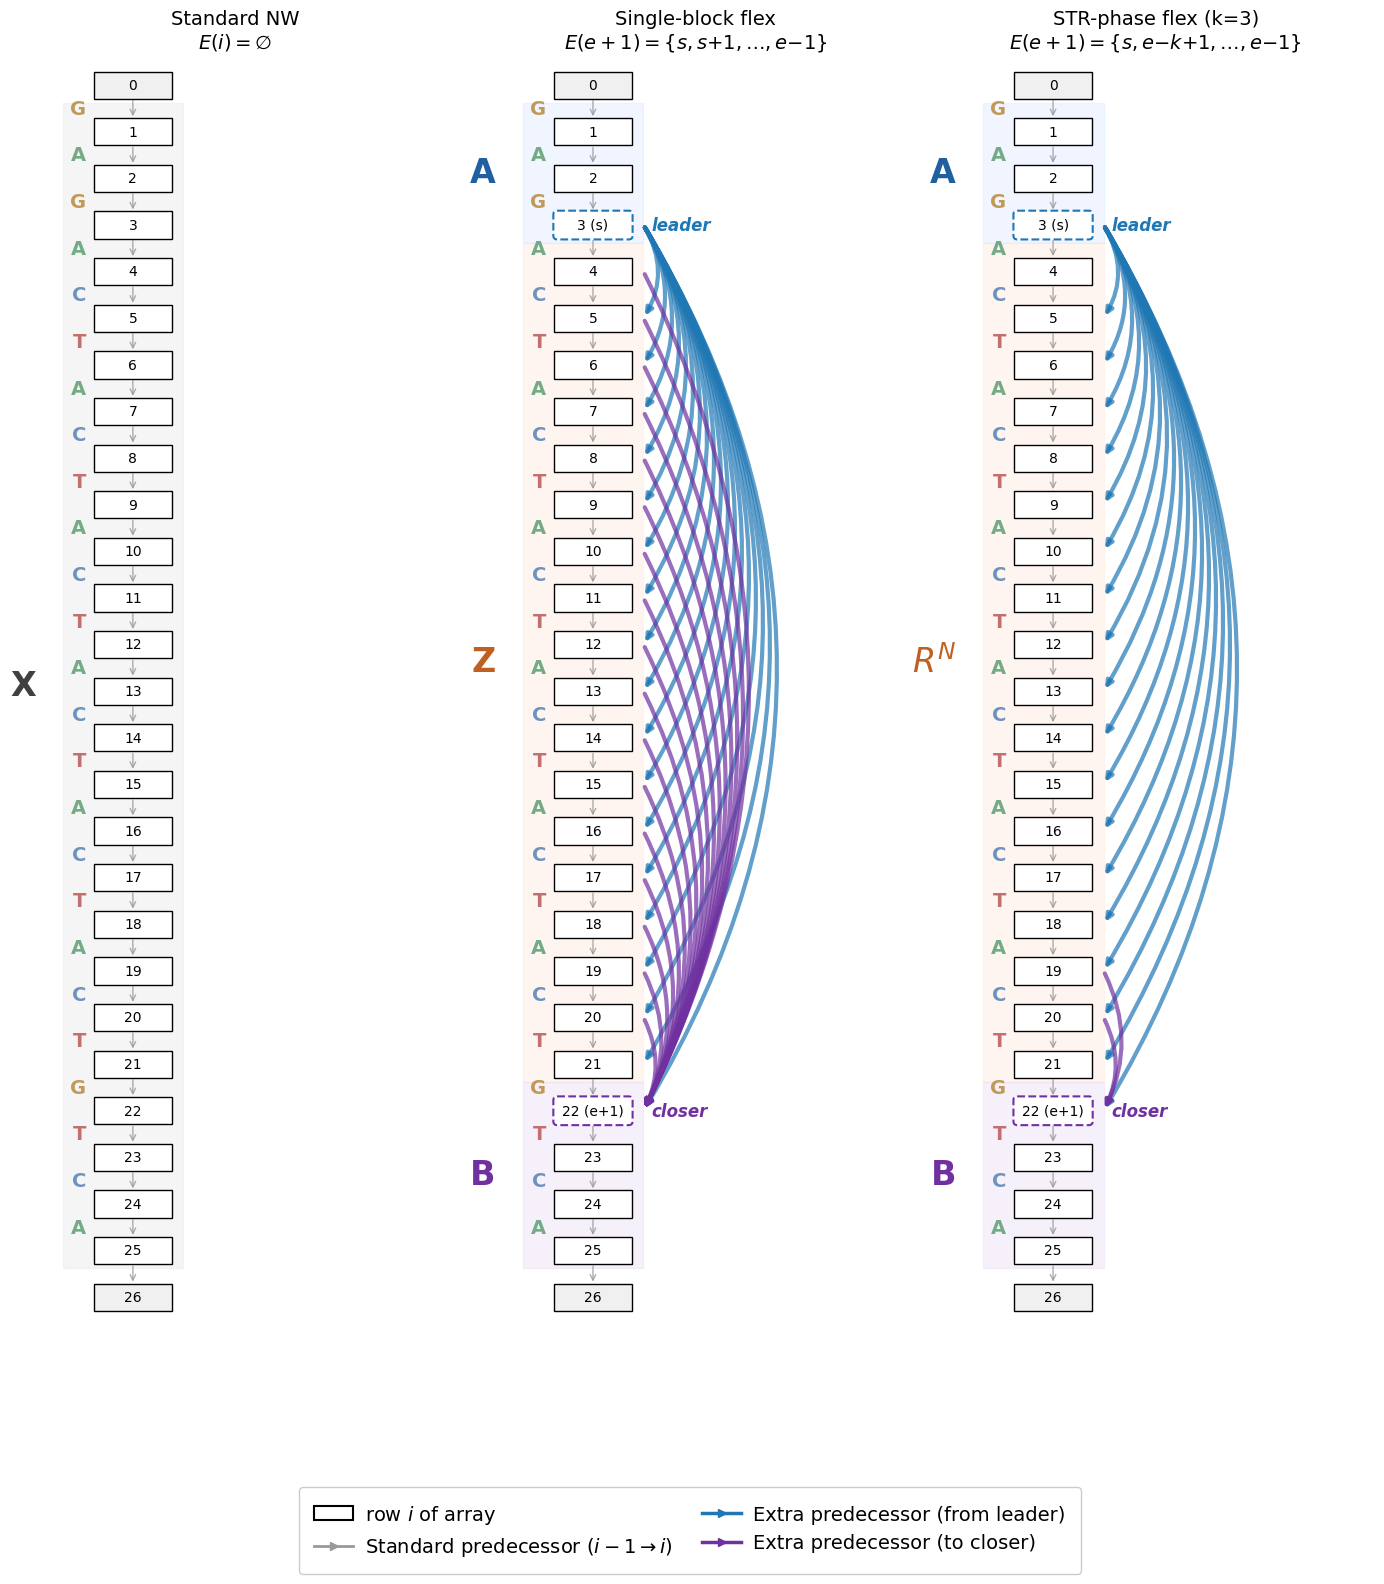

In [7]:
# Colors for background regions
color_A, color_Z, color_B, color_X = "#d0e0ff", "#ffe0d0", "#e0d0f0", "#e0e0e0"
label_A, label_Z, label_B, label_X = "#2060a0", "#c06020", "#7030a0", "#404040"

# Background regions for each pattern
bg_standard = [
    {'start': 1, 'end': n, 'color': color_X,
     'label': 'X', 'label_color': label_X}
]
bg_azb = [
    {'start': 1, 'end': s, 'color': color_A,
     'label': 'A', 'label_color': label_A},
    {'start': s + 1, 'end': e, 'color': color_Z,
     'label': 'Z', 'label_color': label_Z},
    {'start': e + 1, 'end': n, 'color': color_B,
     'label': 'B', 'label_color': label_B},
]
bg_str = [
    {'start': 1, 'end': s, 'color': color_A,
     'label': 'A', 'label_color': label_A},
    {'start': s + 1, 'end': e, 'color': color_Z,
     'label': '$R^N$', 'label_color': label_Z},
    {'start': e + 1, 'end': n, 'color': color_B,
     'label': 'B', 'label_color': label_B},
]

# Titles
titles = [
    "Standard NW\n$E(i) = \\varnothing$",
    "Single-block flex\n$E(e+1) = \\{s, s{+}1, \\ldots, e{-}1\\}$",
    f"STR-phase flex (k={k})\n$E(e+1) = \\{{s, e{{-}}k{{+}}1, \\ldots, e{{-}}1\\}}$",
]

# Row annotations
annot_std = {}
annot_azb = {s: "(s)", e + 1: "(e+1)"}

fig = plot_ep_comparison(
    EP_list=[EP_standard, EP_block, EP_str],
    leaders_list=[[], [s], [s]],
    titles=titles,
    X=locus.X,
    backgrounds=[bg_standard, bg_azb, bg_str],
    row_annotations_list=[annot_std, annot_azb, annot_azb],
    figsize=(14, 18),
    wspace=0.05,
    closer_edge_color="#7030a0",
    leader_curvature=0.3,
    closer_curvature=0.25,
    ep_linewidth=3.0,
    sequence_fontsize=14.0,
    sequence_fontweight="semibold",
    region_fontsize=24.0,
    row_label_fontsize=10.0,
    row_label_fontweight="normal",
    legend_fontsize=14.0,
    row_spacing=1.2,
    node_height=0.7,
    legend_bbox_y=0.04,
    bottom_margin=0.08,
)
plt.show()

## Validating NW-flex for all phase combinations

Having defined the STR EP pattern, we now verify that it correctly handles
**all** valid phase combinations $(a, b, M)$ satisfying the constraint
$M + \mathbf{1}_{\{a>0\}} + \mathbf{1}_{\{b>0\}} \le N$.

For any such triple, the read $Y = A \cdot Z^* \cdot B$ should align perfectly
to the reference $X = A \cdot R^N \cdot B$, achieving a score of
$|Y| \times \text{match\_score}$ (with no gap penalties in the repeat region).

We verify this by:
1. Iterating over all valid $(a, b, M)$ combinations,
2. Constructing the corresponding $Z^*$ and read $Y$,
3. Running NW-flex with the STR EP pattern,
4. Checking that the alignment score matches the expected perfect-match score.

In [ ]:
# Validate all phase combinations
validation_results = []

for a_i, b_i, M_i in valid_combos:
    # Build Z* and Y
    Zstar_i = phase_repeat(locus.R, a_i, b_i, M_i)
    Y_i = locus.build_locus_variant(a_i, b_i, M_i)
    
    # Expected score: perfect match of all |Y| bases
    expected_score = match_score * len(Y_i)
    
    # Run NW-flex with STR EP pattern
    result = align_with_EP(
        X=locus.X,
        Y=Y_i,
        score_matrix=score_matrix,
        gap_open=gap_open,
        gap_extend=gap_extend,
        alphabet_to_index=alphabet_to_index,
        extra_predecessors=EP_str,
        return_data=False,
    )
    
    # Check if score matches expected
    passed = result.score == expected_score
    
    validation_results.append({
        'a': a_i,
        'b': b_i,
        'M': M_i,
        '|Z*|': len(Zstar_i),
        'Z*': Zstar_i,
        '|Y|': len(Y_i),
        'Expected': int(expected_score),
        'Score': int(result.score),
        'Match': "[OK]" if passed else "[FAIL]",
    })

# Display results
df_validation = pd.DataFrame(validation_results)
caption = f"NW-flex validation: R = '{locus.R}' (k={locus.k}), N = {locus.N}"
styled = df_validation.style\
    .set_caption(caption)\
    .set_properties(**{'white-space': 'nowrap', 'padding': '2px 6px'})

display(styled)

# Summary
n_pass = sum(1 for r in validation_results if r['Match'] == "[OK]")
n_total = len(validation_results)
print(f"\nPassed: {n_pass}/{n_total} combinations")

# Show any failures
failures = [r for r in validation_results if r['Match'] == "[FAIL]"]
if failures:
    print("\nFailing cases:")
    for r in failures:
        exp, got = r['Expected'], r['Score']
        print(f"  a={r['a']}, b={r['b']}, M={r['M']}: expected={exp}, got={got}")

,a,b,M,|Z*|,Z*,|Y|,Expected,Score,Match
0,0,0,0,0,,7,35,35,[OK]
1,0,0,1,3,ACT,10,50,50,[OK]
2,0,0,2,6,ACTACT,13,65,65,[OK]
3,0,0,3,9,ACTACTACT,16,80,80,[OK]
4,0,0,4,12,ACTACTACTACT,19,95,95,[OK]
5,0,0,5,15,ACTACTACTACTACT,22,110,110,[OK]
6,0,0,6,18,ACTACTACTACTACTACT,25,125,125,[OK]
7,0,1,0,1,A,8,40,40,[OK]
8,0,1,1,4,ACTA,11,55,55,[OK]
9,0,1,2,7,ACTACTA,14,70,70,[OK]



Passed: 51/51 combinations


## Running NW-flex on an example STR alignment

We now run NW-flex on a specific example and examine the results in detail.
The traceback records row jumps when the alignment uses an extra predecessor
edge. For an STR locus:

- **Entry phase $a$**: When the traceback jumps from the leader row $s$ into
  the block, the landing row determines $a$.

- **Exit phase $b$**: When the traceback jumps from some row $i$ in the block
  to the closer row $e+1$, the departure row determines $b$.

- **Complete units $M$**: The number of complete motif copies is computed from
  the total length of $Z^*$ and the phases $a$, $b$.

The `infer_abM_from_jumps()` function recovers these parameters from the
traceback.

In [9]:
# Run alignment with our example (a=2, b=1, M=2)
result = align_with_EP(
    X=locus.X,
    Y=Y,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    alphabet_to_index=alphabet_to_index,
    extra_predecessors=EP_str,
    return_data=True,
)

print(f"Alignment score: {result.score}")
print(f"Aligned X: {result.X_aln}")
print(f"Aligned Y: {result.Y_aln}")
print()
print(f"Row jumps: {result.jumps}")

Alignment score: 80.0
Aligned X: GAGCTACTACTAGTCA
Aligned Y: GAGCTACTACTAGTCA

Row jumps: [RowJump(from_row=3, to_row=11, col=4, state=1), RowJump(from_row=19, to_row=22, col=13, state=1)]


In [10]:
# Infer (a, b, M) from the row jumps
a_inf, b_inf, M_inf = infer_abM_from_jumps(result.jumps, locus.s, locus.e, locus.k)

if a_inf is not None:
    Zstar_inf = phase_repeat(locus.R, a_inf, b_inf, M_inf)
else:
    Zstar_inf = "?"

print("Phase inference from traceback:")
print(f"  Original (a, b, M) = ({a}, {b}, {M})")
print(f"  Inferred (a, b, M) = ({a_inf}, {b_inf}, {M_inf})", end="")
print(f" {'[OK]' if (a, b, M) == (a_inf, b_inf, M_inf) else '[FAIL]'}")
print()
print(f"  Original Z* = '{Zstar}'")
print(f"  Inferred Z* = '{Zstar_inf}'", end="")
print(f" {'[OK]' if Zstar_inf == Zstar else '[FAIL]'}")

Phase inference from traceback:
  Original (a, b, M) = (2, 1, 2)
  Inferred (a, b, M) = (2, 1, 2) [OK]

  Original Z* = 'CTACTACTA'
  Inferred Z* = 'CTACTACTA' [OK]


### Visualizing the DP matrices

We plot the three DP layers ($Y_g$, $M$, $X_g$) with the optimal path overlaid.
The row jumps show how the alignment enters and exits the repeat block.

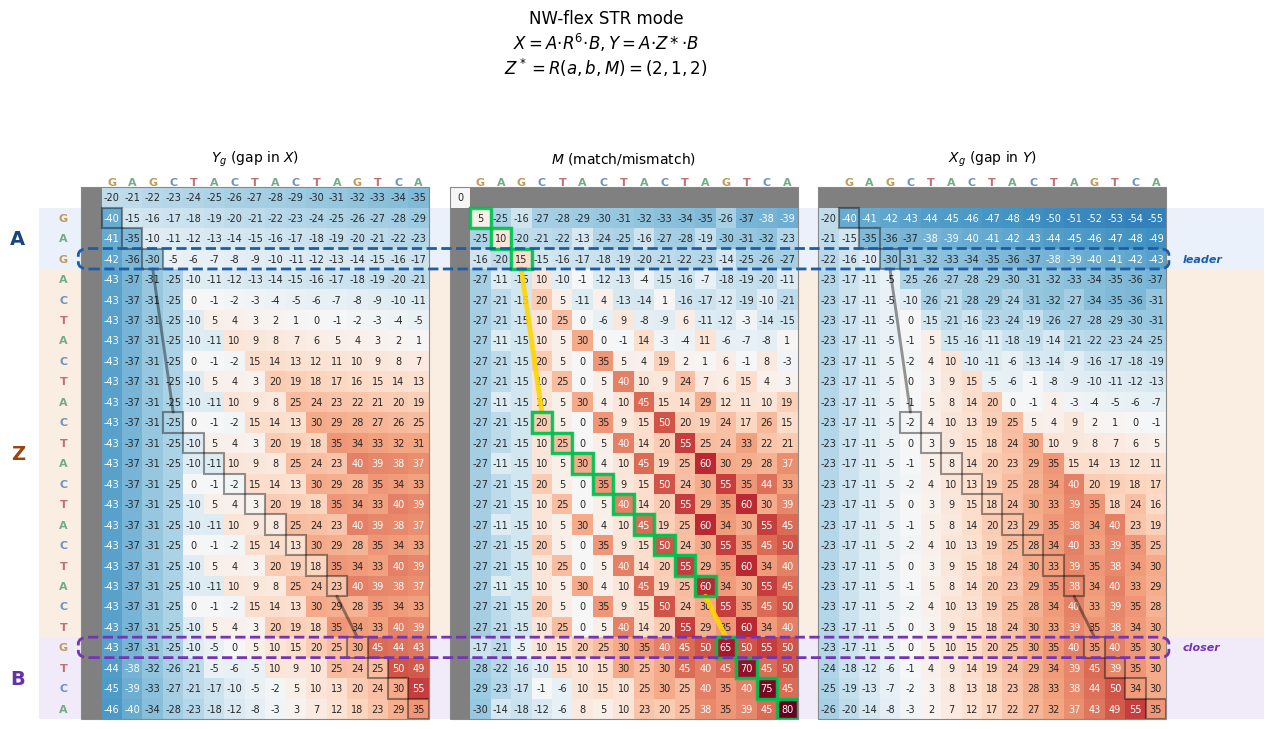

In [11]:
# Plot the DP matrices with alignment path using publication-quality plotter
n = len(locus.X)

# Build A·Z·B regions for background fills
regions = [
    {'start': 1, 'end': locus.s, 'label': 'A',
     'fill_color': REGION_FILL_COLORS['A'], 'label_color': REGION_LABEL_COLORS['A']},
    {'start': locus.s + 1, 'end': locus.e, 'label': 'Z',
     'fill_color': REGION_FILL_COLORS['Z'], 'label_color': REGION_LABEL_COLORS['Z']},
    {'start': locus.e + 1, 'end': n, 'label': 'B',
     'fill_color': REGION_FILL_COLORS['B'], 'label_color': REGION_LABEL_COLORS['B']},
] if locus.s >= 1 else []

# Create figure with GridSpec for the 3 matrices
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(1, 3, wspace=0.06)
axes = [fig.add_subplot(gs[i]) for i in range(3)]

# Plot using publication-quality plotter
plot_flex_matrices_publication(
    fig=fig,
    axes=axes,
    result=result,
    X=locus.X,
    Y=Y,
    s=locus.s,
    e=locus.e,
    regions=regions,
    colormap=grid_color_map,
    title_pad=18,
    nuc_label_fontsize=8,
)

title = (f"NW-flex STR mode\n"
         f"$X = A·R^{{{locus.N}}}·B, Y = A·Z*·B$\n"
         f"$Z^* = R(a,b,M) = ({a},{b},{M})$")
fig.suptitle(title, y=1.05)
plt.show()

## Scalar plateau of $S_{\mathrm{flex}}(X_N, Y)$ vs $N$

A key property of the STR EP pattern is that the flex score
$S_{\mathrm{flex}}(X_N, Y)$ is **non-decreasing** in the reference copy number
$N$ and **plateaus** once $X_N = A \cdot R^N \cdot B$ contains enough copies
to optimally align the read.

For a read $Y = A \cdot Z^* \cdot B$ where $Z^* = \mathrm{phase}(R, a, b, M)$,
the "repeat content" is
$$
\text{repeat content} = M + \mathbf{1}_{\{a>0\}} + \mathbf{1}_{\{b>0\}}.
$$

The flex score plateaus precisely when $N$ reaches this value: the reference
then contains exactly enough repeat material to accommodate $Z^*$ with a
perfect match.

We demonstrate this by plotting the flex score for **four different reads**,
each with a different phase combination $(a, b, M)$:

| Case | $(a, b, M)$ | Repeat content | Description |
|------|-------------|----------------|-------------|
| 1 | $(0, 0, 3)$ | 3 | No partial repeats |
| 2 | $(1, 0, 2)$ | 3 | Left partial only |
| 3 | $(0, 2, 2)$ | 3 | Right partial only |
| 4 | $(2, 1, 2)$ | 4 | Both partials |

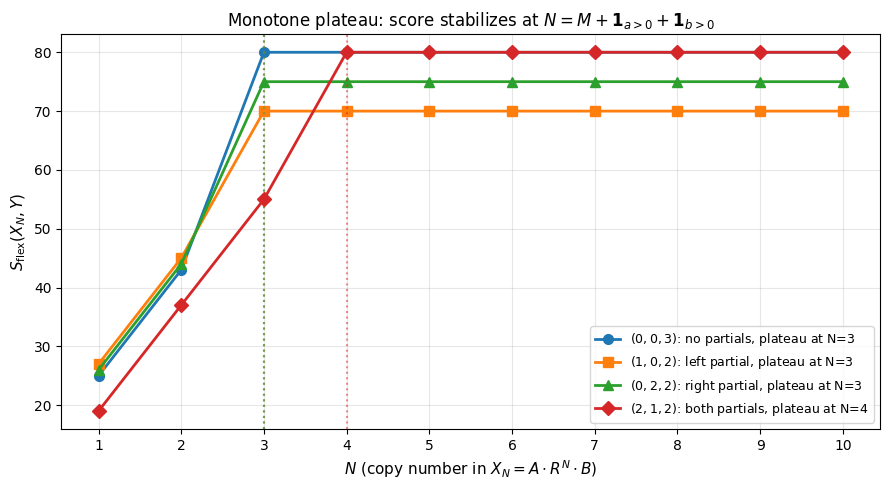

In [ ]:
def str_flex_score_for_N(N_test: int, A: str, R: str, B: str, Y_fixed: str) -> float:
    """Compute S_flex(X_N, Y) for X_N = A · R^N · B."""
    X_N = A + R * N_test + B
    s_N = len(A)
    e_N = len(A) + len(R) * N_test
    k_N = len(R)
    
    EP_N = build_EP_STR_phase(len(X_N), s=s_N, e=e_N, k=k_N)
    result_N = align_with_EP(
        X=X_N,
        Y=Y_fixed,
        score_matrix=score_matrix,
        gap_open=gap_open,
        gap_extend=gap_extend,
        alphabet_to_index=alphabet_to_index,
        extra_predecessors=EP_N,
        return_data=False,
    )
    return result_N.score

# Define four test cases with different (a, b, M) combinations
test_cases = [
    (0, 0, 3, "$(0,0,3)$: no partials"),      # repeat content = 3
    (1, 0, 2, "$(1,0,2)$: left partial"),     # repeat content = 3
    (0, 2, 2, "$(0,2,2)$: right partial"),    # repeat content = 3
    (2, 1, 2, "$(2,1,2)$: both partials"),    # repeat content = 4
]

# Vary N from 1 to 10
N_values = list(range(1, 11))

# Plot all cases on the same figure
plt.figure(figsize=(9, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']

for idx, (a_test, b_test, M_test, label) in enumerate(test_cases):
    # Build Y for this (a, b, M)
    Y_test = locus.build_locus_variant(a_test, b_test, M_test)
    
    # Compute repeat content (plateau point)
    overhead = (1 if a_test > 0 else 0) + (1 if b_test > 0 else 0)
    repeat_content = M_test + overhead
    
    # Compute scores for each N
    scores = [
        str_flex_score_for_N(N_i, locus.A, locus.R, locus.B, Y_test)
        for N_i in N_values
    ]
    
    # Plot curve
    plt.plot(
        N_values, scores, marker=markers[idx], linewidth=2, markersize=7,
        color=colors[idx], label=f"{label}, plateau at N={repeat_content}"
    )
    
    # Add vertical line at plateau point
    plt.axvline(
        x=repeat_content, color=colors[idx],
        linestyle=':', alpha=0.5, linewidth=1.5
    )

plt.xlabel("$N$ (copy number in $X_N = A \\cdot R^N \\cdot B$)", fontsize=11)
plt.ylabel("$S_{\\mathrm{flex}}(X_N, Y)$", fontsize=11)
title = "Monotone plateau: score stabilizes at " \
        "$N = M + \\mathbf{1}_{a>0} + \\mathbf{1}_{b>0}$"
plt.title(title, fontsize=12)
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(N_values)
plt.tight_layout()
plt.show()

Each curve reaches its maximum (plateau) exactly when
$N = M + \mathbf{1}_{\{a>0\}} + \mathbf{1}_{\{b>0\}}$, as indicated by the
dotted vertical lines. The three cases with repeat content 3 all plateau at
$N = 3$, while case 4 (with both partial repeats) plateaus at $N = 4$.

This confirms that the STR EP pattern correctly identifies the minimum
reference length needed to optimally align any phased read.

## Phase-wise monotonicity in the DP grid

The scalar plateau we observed above is a consequence of a finer-grained
property: **phase-wise monotonicity** in each layer of the Gotoh DP.

Inside the STR block $Z = R^N$ (rows $s+1, \ldots, e$), we group rows by
their **motif phase**:

- For a given phase offset $r \in \{0, 1, \ldots, k-1\}$, consider the row indices
  $$
  i_n = s + 1 + r + n \cdot k
  $$
  such that $s + 1 \le i_n \le e$.

For a fixed column $j$ and **each Gotoh layer** ($Y_g$, $M$, $X_g$), the sequence
of scores along these phase-equivalent rows is **non-decreasing** in $n$:
$$
L(i_0, j) \le L(i_1, j) \le L(i_2, j) \le \cdots
$$
where $L \in \{Y_g, M, X_g\}$.

Intuitively: once the repeat block is long enough to represent a good partial
match, extending it by whole-copy increments of $R$ cannot reduce the score.
The scores rise and then plateau, mirroring the scalar behavior we saw earlier.

In [13]:
# Get DP data from the alignment result
data = result.data
n_rows, n_cols = data.M.shape
print(f"DP grid shape: {n_rows} rows × {n_cols} columns")

# Helper to get rows for a given phase r inside Z
def phase_rows(s: int, e: int, k: int, r: int):
    """Get row indices inside Z with phase r."""
    rows = []
    i = s + 1 + r
    while i <= e:
        rows.append(i)
        i += k
    return rows

# Check monotonicity for all phases, columns, and layers
layers = [('Yg', data.Yg), ('M', data.M), ('Xg', data.Xg)]
violations = []

for layer_name, layer_mat in layers:
    for r in range(k):
        rows_r = phase_rows(s, e, k, r)
        if len(rows_r) <= 1:
            continue
        for j in range(1, n_cols):
            vals = [layer_mat[i, j] for i in rows_r]
            for idx in range(len(vals) - 1):
                if vals[idx + 1] < vals[idx]:
                    violations.append((layer_name, r, j, rows_r, vals))
                    break

if not violations:
    print("[OK] All phase-wise sequences are non-decreasing in Yg, M, and Xg.")
else:
    print(f"[FAIL] Found {len(violations)} violations:")
    for (layer, r, j, rows_r, vals) in violations[:5]:
        print(f"  {layer}: phase r={r}, col j={j}, values={vals}")

DP grid shape: 26 rows × 17 columns
[OK] All phase-wise sequences are non-decreasing in Yg, M, and Xg.


### Visualizing phase-wise monotonicity

We plot the score sequences along rows $i = s + 1 + r + n \cdot k$ for each
phase $r$ and each Gotoh layer ($Y_g$, $M$, $X_g$). Each curve shows how the
score changes as we add more repeat copies ($n$ increases).

Non-decreasing curves rising to a plateau confirm the phase-wise monotonicity
property—the same pattern we saw in the scalar flex score.

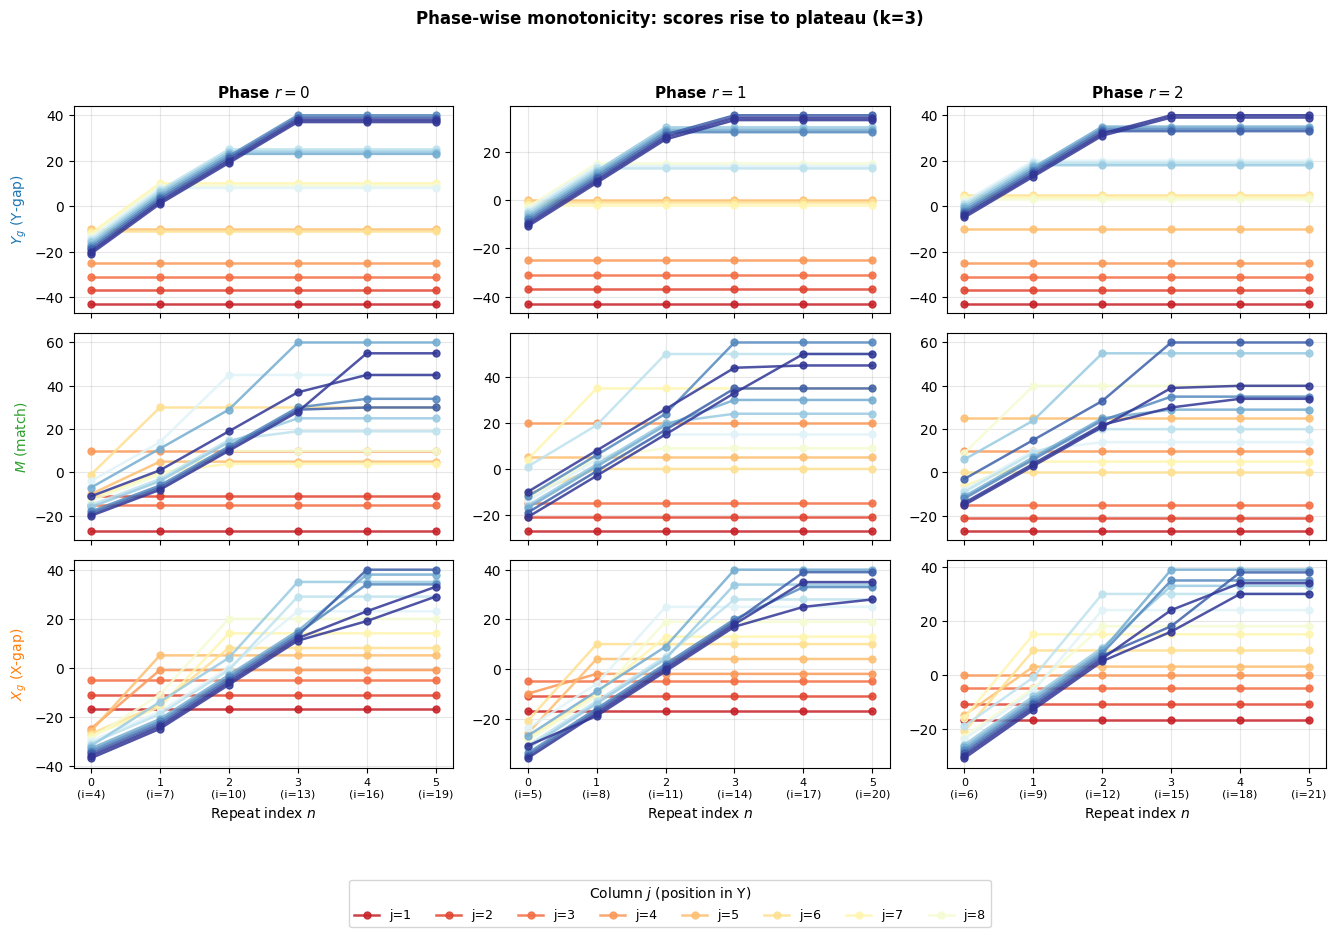

In [14]:
def plot_phase_monotonicity_lines(data, s, e, k, Y, figsize=None):
    """
    Plot score sequences along rows i = (s+1) + r + n*k for each phase r
    and Gotoh layer (Yg, M, Xg).
    
    Each curve shows how the score changes as we add more repeat copies (n).
    Non-decreasing curves rising to a plateau confirm phase-wise monotonicity.
    """
    Yg, M_mat, Xg = data.Yg, data.M, data.Xg
    n_rows, n_cols = Yg.shape
    
    # Show columns based on Y length (the repeat region of Y)
    cols_to_show = min(n_cols, len(Y) + 1)
    
    # Layers to plot
    layers = [
        ('$Y_g$ (Y-gap)', Yg, '#1f77b4'),
        ('$M$ (match)', M_mat, '#2ca02c'),
        ('$X_g$ (X-gap)', Xg, '#ff7f0e'),
    ]
    
    # Get phases with multiple rows
    def get_phase_rows(r):
        rows = []
        i = s + 1 + r
        while i <= e:
            rows.append(i)
            i += k
        return rows
    
    phases_with_rows = [(r, get_phase_rows(r)) for r in range(k)]
    phases_with_rows = [(r, rows) for r, rows in phases_with_rows if len(rows) > 1]
    
    n_phases = len(phases_with_rows)
    n_layers = len(layers)
    
    if figsize is None:
        figsize = (4.5 * n_phases, 3 * n_layers)
    
    fig, axes = plt.subplots(n_layers, n_phases, figsize=figsize, sharex='col')
    
    # Handle edge cases
    if n_phases == 1:
        axes = axes.reshape(-1, 1)
    if n_layers == 1:
        axes = axes.reshape(1, -1)
    
    # Use plasma colormap for column colors
    cmap = plt.cm.RdYlBu
    col_colors = [
        cmap(j / max(1, cols_to_show - 2))
        for j in range(1, cols_to_show)
    ]
    
    for layer_idx, (layer_name, layer_mat, layer_color) in enumerate(layers):
        for phase_idx, (r, rows_r) in enumerate(phases_with_rows):
            ax = axes[layer_idx, phase_idx]
            
            # n values (repeat copy index)
            n_vals = list(range(len(rows_r)))
            
            # Plot a line for each column j
            for col_idx, j in enumerate(range(1, cols_to_show)):
                scores = [layer_mat[i, j] for i in rows_r]
                
                label = f"j={j}" if col_idx < 8 else None
                ax.plot(
                    n_vals, scores,
                    marker='o', markersize=5,
                    linestyle='-', linewidth=1.8,
                    color=col_colors[col_idx],
                    label=label,
                    alpha=0.85,
                )
            
            # Styling
            if layer_idx == 0:
                ax.set_title(f"Phase $r = {r}$", fontsize=11, fontweight='semibold')
            if layer_idx == n_layers - 1:
                ax.set_xlabel("Repeat index $n$", fontsize=10)
            if phase_idx == 0:
                ax.set_ylabel(f"{layer_name}", fontsize=10, color=layer_color)
            
            ax.grid(True, alpha=0.3)
            ax.set_xticks(n_vals)
            
            # Add row index annotations on bottom row
            if layer_idx == n_layers - 1:
                labels = [f"{n}\n(i={rows_r[n]})" for n in n_vals]
                ax.set_xticklabels(labels, fontsize=8)
            else:
                ax.set_xticklabels([])
    
    # Add shared legend at bottom
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.02),
        ncol=min(10, len(handles)),
        fontsize=9,
        title="Column $j$ (position in Y)",
        title_fontsize=10,
    )
    
    fig.suptitle(
        f"Phase-wise monotonicity: scores rise to plateau (k={k})",
        fontsize=12, fontweight='semibold',
    )
    
    plt.tight_layout(rect=[0, 0.06, 1, 0.95])
    
    return fig

# Plot the phase monotonicity lines
fig = plot_phase_monotonicity_lines(data, s, e, k, Y)
plt.show()

The rising-plateau curves in each panel mirror the scalar flex score behavior:
as we move deeper into the repeat block along the same motif phase, the DP can
always "reuse" or extend a good partial match without losing score.

This phase-wise monotonicity in the DP grid is the mechanism underlying the
scalar plateau: once the reference contains enough copies, further extension
cannot improve the alignment.

## Multi-block STR example (compound repeats)

Real STR loci sometimes contain multiple adjacent repeat blocks with different
motifs. A **compound STR** has the form:
$$
X = A \cdot R_1^{N_1} \cdot R_2^{N_2} \cdot B
$$
where $R_1$ and $R_2$ are different motifs (possibly with different lengths).

The `build_EP_multi_STR_phase()` function constructs an EP pattern that handles
multiple STR blocks by taking the union of the individual block patterns. Each
block has its own leader row, closer row, and phase-preserving exit condition.

We demonstrate this with a compound locus containing two blocks:
- Block 1: $R_1 = \texttt{AC}$ with $N_1 = 4$
- Block 2: $R_2 = \texttt{TGG}$ with $N_2 = 3$

In [15]:
# Define a compound STR locus with two blocks
compound = CompoundSTRLocus(
    A="GAT",
    blocks=[("AC", 4), ("TGG", 3)],  # (R1, N1), (R2, N2)
    B="CTA",
)

print(f"Compound locus: X = A · R1^N1 · R2^N2 · B")
print(f"  A = '{compound.A}'")
print(f"  R1 = 'AC', N1 = 4")
print(f"  R2 = 'TGG', N2 = 3")
print(f"  B = '{compound.B}'")
print()
print(f"Reference X: {compound.X} (length {compound.n})")
print()

# Get block boundaries
boundaries = compound.block_boundaries()
print("Block boundaries (s, e, k):")
for i, (s_i, e_i, k_i) in enumerate(boundaries):
    print(f"  Block {i+1}: s={s_i}, e={e_i}, k={k_i}")

Compound locus: X = A · R1^N1 · R2^N2 · B
  A = 'GAT'
  R1 = 'AC', N1 = 4
  R2 = 'TGG', N2 = 3
  B = 'CTA'

Reference X: GATACACACACTGGTGGTGGCTA (length 23)

Block boundaries (s, e, k):
  Block 1: s=3, e=11, k=2
  Block 2: s=11, e=20, k=3


In [16]:
# Build the multi-block EP pattern
n_compound = compound.n
EP_multi = build_EP_multi_STR_phase(n_compound, boundaries)

# Create a read with partial content from both blocks
# Block 1: use (a1=1, b1=0, M1=2) -> suf(AC,1)·AC^2 = "C" + "ACAC" = "CACAC"
# Block 2: use (a2=0, b2=2, M2=1) -> TGG^1·pre(TGG,2) = "TGG" + "TG" = "TGGTG"
R1, N1 = compound.blocks[0]
R2, N2 = compound.blocks[1]

Z1_star = phase_repeat(R1, a=1, b=0, M=2)  # "CACAC"
Z2_star = phase_repeat(R2, a=0, b=2, M=1)  # "TGGTG"

Y_compound = compound.A + Z1_star + Z2_star + compound.B

print(f"Read Y with partial content from both blocks:")
print(f"  Z1* = phase('{R1}', 1, 0, 2) = '{Z1_star}'")
print(f"  Z2* = phase('{R2}', 0, 2, 1) = '{Z2_star}'")
print(f"  Y = A + Z1* + Z2* + B = '{Y_compound}'")
print(f"  |Y| = {len(Y_compound)}")

Read Y with partial content from both blocks:
  Z1* = phase('AC', 1, 0, 2) = 'CACAC'
  Z2* = phase('TGG', 0, 2, 1) = 'TGGTG'
  Y = A + Z1* + Z2* + B = 'GATCACACTGGTGCTA'
  |Y| = 16


In [17]:
# Run alignment
result_compound = align_with_EP(
    X=compound.X,
    Y=Y_compound,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    alphabet_to_index=alphabet_to_index,
    extra_predecessors=EP_multi,
    return_data=True,
)

# Expected score: perfect match
expected_compound = match_score * len(Y_compound)

print(f"Alignment score: {result_compound.score}")
print(f"Expected score:  {expected_compound}")
print(f"Match: {'[OK]' if result_compound.score == expected_compound else '[FAIL]'}")
print()
print(f"Aligned X: {result_compound.X_aln}")
print(f"Aligned Y: {result_compound.Y_aln}")
print()
print("Row jumps:", *result_compound.jumps, sep="\n")

Alignment score: 80.0
Expected score:  80.0
Match: [OK]

Aligned X: GATCACACTGGTGCTA
Aligned Y: GATCACACTGGTGCTA

Row jumps:
RowJump(from_row=3, to_row=7, col=4, state=1)
RowJump(from_row=11, to_row=15, col=9, state=1)
RowJump(from_row=19, to_row=21, col=14, state=1)


### Visualizing the multi-block alignment

We plot the DP matrices for the compound locus. The two repeat blocks are
highlighted separately, showing how the alignment jumps through each block
independently.

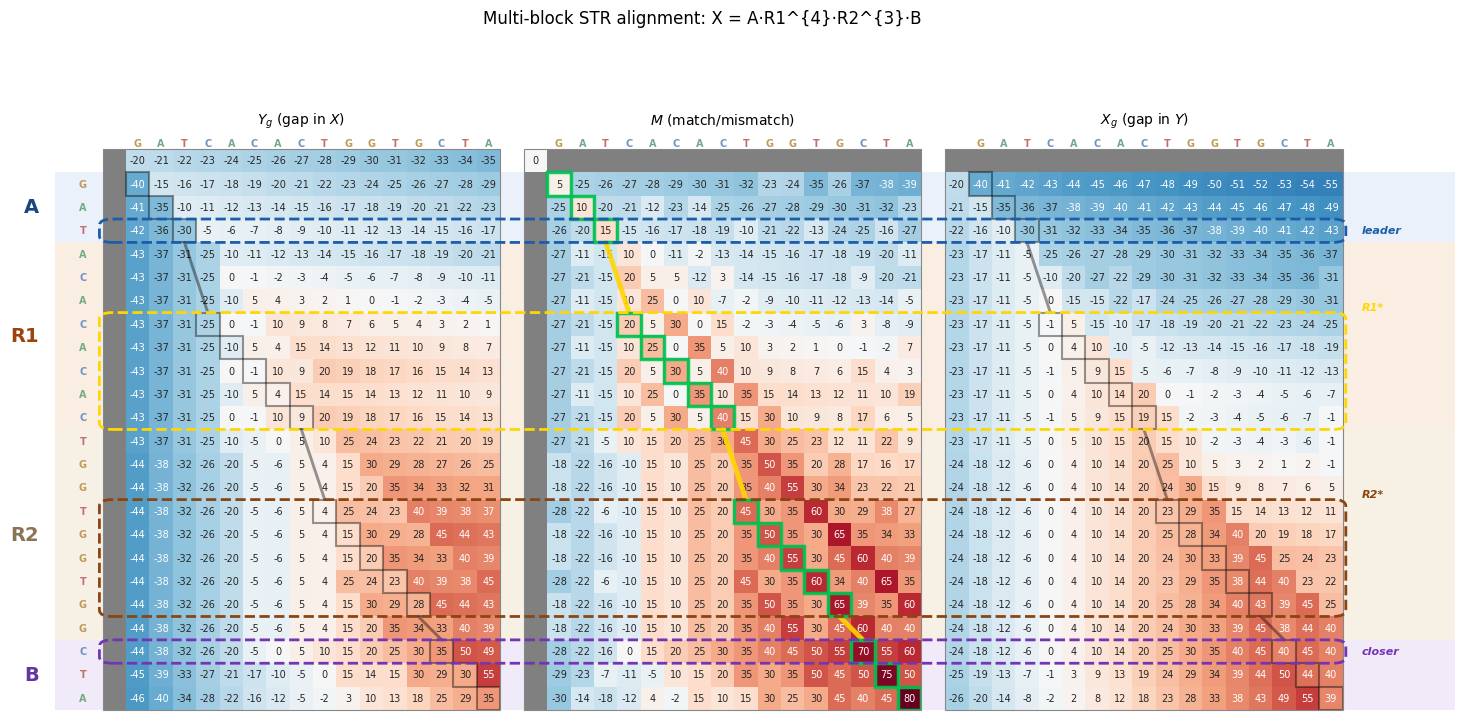

In [18]:
# For multi-block, we use the first block's boundaries for the main visualization
s1, e1, k1 = boundaries[0]
s2, e2, k2 = boundaries[1]
n = len(compound.X)

# Build regions for compound STR (A, R1 block, R2 block, B)
regions = [
    {'start': 1, 'end': s1, 'label': 'A',
     'fill_color': REGION_FILL_COLORS['A'], 'label_color': REGION_LABEL_COLORS['A']},
    {'start': s1 + 1, 'end': e1, 'label': 'R1',
     'fill_color': REGION_FILL_COLORS['Z'], 'label_color': REGION_LABEL_COLORS['Z']},
    {'start': e1 + 1, 'end': e2, 'label': 'R2',
     'fill_color': '#E8D5B7', 'label_color': '#8B7355'},  # Tan for R2
    {'start': e2 + 1, 'end': n, 'label': 'B',
     'fill_color': REGION_FILL_COLORS['B'], 'label_color': REGION_LABEL_COLORS['B']},
] if s1 >= 1 else []

# Extract R1* and R2* boundaries from jumps
# Multi-block compound STR has 3 jumps:
#   Jump 0: entry into R1 (from leader s1)
#   Jump 1: exit R1 / entry R2 (from R1 to R2)
#   Jump 2: exit R2 (to closer)
# Use cyan and yellow - highly visible against red background
BROWN = '#8B4513'      # Light Brown - visible against red
YELLOW = '#FFD700'    # Gold/yellow - visible against red
row_highlights = []

if len(result_compound.jumps) >= 3:
    # R1* boundaries: entry is jump[0].to_row, exit is jump[1].from_row
    r1_star_start = result_compound.jumps[0].to_row
    r1_star_end = result_compound.jumps[1].from_row
    
    # R2* boundaries: entry is jump[1].to_row, exit is jump[2].from_row
    r2_star_start = result_compound.jumps[1].to_row
    r2_star_end = result_compound.jumps[2].from_row
    
    row_highlights = [
        {'start': r1_star_start, 'end': r1_star_end, 'label': 'R1*',
         'color': YELLOW, 'linestyle': '--', 'label_position': 'top'},
        {'start': r2_star_start, 'end': r2_star_end, 'label': 'R2*',
         'color': BROWN, 'linestyle': '--', 'label_position': 'top'},
    ]

# Create figure with GridSpec for the 3 matrices
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 3, wspace=0.06)
axes = [fig.add_subplot(gs[i]) for i in range(3)]

# Plot using publication-quality plotter
plot_flex_matrices_publication(
    fig=fig,
    axes=axes,
    result=result_compound,
    X=compound.X,
    Y=Y_compound,
    s=s1,  # Use first block's leader
    e=e2,  # Use second block's end
    regions=regions,
    row_highlights=row_highlights,
    colormap=grid_color_map,
    title_pad=18,
    nuc_label_fontsize=7,
)

fig.suptitle(f"Multi-block STR alignment: X = A·R1^{{{N1}}}·R2^{{{N2}}}·B", y=1.02)
plt.show()

---

## Summary

In this notebook, we developed the **STR specialization** of the NW-Flex algorithm, demonstrating how the general framework from Notebooks 02-03 applies to Short Tandem Repeat analysis.

### Key Concepts

1. **STR Locus Structure**: An STR locus has the form $X = A \cdot R^N \cdot B$, where:
   - $A$ = left flanking sequence (leader)
   - $R$ = repeat unit of length $k$
   - $N$ = number of repeat copies
   - $B$ = right flanking sequence (trailer)

2. **Phased Query Sequences**: Valid query sequences for STR loci have the form:
   $$Z^* = \text{suf}(R, a) \cdot R^M \cdot \text{pre}(R, b)$$
   where $a, b \in \{0, 1, \ldots, k-1\}$ define the phase and $M$ is the number of complete repeats.

3. **The Fundamental Constraint**: The $(a, b, M)$ triplet must satisfy:
   $$M + \mathbf{1}_{a > 0} + \mathbf{1}_{b > 0} \le N$$
   This ensures the query can be accommodated within the reference.

4. **EP Pattern for STRs**: The `build_EP_STR_phase` function constructs the equal-penalty pattern that:
   - Allows entry from the leader row $s$ into any row of the repeat block
   - Allows exit only from phase-compatible rows $\{s, e-k+1, \ldots, e\}$
   - Encodes the phase information $(a, b)$ in the entry/exit points

### Validation Results

We verified that **all valid $(a, b, M)$ combinations** produce:

- Perfect alignment scores (equal to query length × match bonus)
- Correct phase inference from jump analysis
- Proper constraint satisfaction

### Monotonicity Properties

1. **Scalar plateau**: The flex score $S_{\mathrm{flex}}(X_N, Y)$ is non-decreasing in $N$ and plateaus exactly at
   $$N = M + \mathbf{1}_{a > 0} + \mathbf{1}_{b > 0}$$
   the minimum reference copy number needed to optimally align the read.

2. **Phase-wise monotonicity**: For fixed column $j$ and phase $r$, the DP scores $F(i, j)$ along rows $i = s + 1 + r + nk$ are non-decreasing in $n$.

### Multi-block Extension

The framework extends naturally to **compound STR loci** with multiple repeat blocks:
$$X = A \cdot R_1^{N_1} \cdot R_2^{N_2} \cdot B$$

Using `CompoundSTRLocus` and `build_EP_multi_STR_phase`, each block maintains its own phase parameters while sharing a common alignment coordinate system.

---

### Next Steps

- **Notebook 05**: Explores the C++ accelerated implementation for production-scale analysis
- **Application**: Apply STR-EP to real genomic data with biological repeat units